In [20]:
# Import dependencies

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np



In [21]:
# Set the path to the dataset
dataset_path = "Dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

In [22]:
# Print the content of the training directory
# Print the content of the training directory
print("Training directory contents:")
for folder in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"Folder Name: {folder}")
        print(f"Number of Files: {num_files}")
        print("------------------------")

# Print the content of the testing directory
print("\nTesting directory contents:")
for folder in os.listdir(train_dir):
    folder_path = os.path.join(test_dir, folder)
    
    # Check if it's a directory
    if os.path.isdir(folder_path):
        num_files = len(os.listdir(folder_path))
        print(f"Folder Name: {folder}")
        print(f"Number of Files: {num_files}")
        print("------------------------")

Training directory contents:
Folder Name: no_tumor
Number of Files: 395
------------------------
Folder Name: meningioma_tumor
Number of Files: 822
------------------------
Folder Name: glioma_tumor
Number of Files: 826
------------------------
Folder Name: pituitary_tumor
Number of Files: 827
------------------------

Testing directory contents:
Folder Name: no_tumor
Number of Files: 105
------------------------
Folder Name: meningioma_tumor
Number of Files: 115
------------------------
Folder Name: glioma_tumor
Number of Files: 100
------------------------
Folder Name: pituitary_tumor
Number of Files: 74
------------------------


In [23]:
# Define necessary variables

# # Set the image size
# image_size = (224, 224)

# # Set the batch size for training
# batch_size = 32

# # Set the number of epochs for training
# epochs = 50

# # Define the categories
# categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]


# Paths to the dataset
train_dir = "Dataset/Training"
test_dir = "Dataset/Testing"

# Hyperparameters
IMAGE_SIZE = (224, 224)  # ResNet50 standard size
BATCH_SIZE = 32
NUM_CLASSES = 4  # Number of classes in your dataset
EPOCHS = 25
LEARNING_RATE = 0.0001



In [24]:
# Data generators for training and validation/testing datasets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training data with validation split
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Load testing data
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [25]:
# Load the ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adding custom layers on top of ResNet50
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)  # Custom dense layer
output = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer


# Freeze the base_model layers to avoid training them initially
for layer in base_model.layers:
    layer.trainable = False

# Final model
# model = Model(inputs=base_model.input, outputs=output)

# Build the full model
model = Sequential([
    base_model,               
    Flatten(),                
    Dense(256, activation='relu'),  
    Dropout(0.5),             # Dropout to prevent overfitting
    Dense(4, activation='softmax')  # Output layer for 4 brain tumor classes
])

# Compile the model
model.compile(optimizer=Adam(LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________


In [28]:
from keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (you can change to 'val_accuracy')
    patience=3,            # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best model's weights after stopping
)

In [29]:
# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE,
    callbacks=[early_stopping]
)


# history = model.fit(
#     train_data,
#     validation_data=test_data,
#     epochs=30,
#     callbacks=[early_stopping]
# )

Epoch 1/25


2024-10-27 01:34:09.717501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-10-27 01:34:09.728727: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


71/71 [==============================] - ETA: 0s - loss: 1.4188 - accuracy: 0.4296

2024-10-27 01:35:12.503699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


71/71 [==============================] - 77s 1s/step - loss: 1.4188 - accuracy: 0.4296 - val_loss: 1.1977 - val_accuracy: 0.4191
Epoch 2/25
71/71 [==============================] - 74s 1s/step - loss: 1.0813 - accuracy: 0.5294 - val_loss: 1.1422 - val_accuracy: 0.4467
Epoch 3/25
71/71 [==============================] - 73s 1s/step - loss: 1.0044 - accuracy: 0.5704 - val_loss: 1.1553 - val_accuracy: 0.3952
Epoch 4/25
71/71 [==============================] - 81s 1s/step - loss: 0.9792 - accuracy: 0.5987 - val_loss: 1.0721 - val_accuracy: 0.5184
Epoch 5/25
71/71 [==============================] - 70s 990ms/step - loss: 0.9210 - accuracy: 0.6159 - val_loss: 1.0850 - val_accuracy: 0.4982
Epoch 6/25
71/71 [==============================] - 77s 1s/step - loss: 0.8795 - accuracy: 0.6380 - val_loss: 1.0754 - val_accuracy: 0.4945
Epoch 7/25
71/71 [==============================] - 70s 980ms/step - loss: 0.8560 - accuracy: 0.6468 - val_loss: 1.0431 - val_accuracy: 0.4632
Epoch 8/25
71/71 [=======

#### Observations:
### Epoch Time: Epoch time varies between 70s to 150s.
### Loss: Training loss decreases from 1.4188 to 0.7254 (48.8% reduction).
### Accuracy: Training accuracy increases from 42.96% to 69.58% (26.62% improvement).
### Validation Loss: Validation loss decreases from 1.1977 to 1.0146 (15.3% reduction).
### Validation Accuracy: Validation accuracy increases from 41.91% to 54.96% (13.05% improvement).


In [32]:
# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


2024-10-27 17:29:51.169694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 11s 873ms/step - loss: 2.1742 - accuracy: 0.4188
Test Loss: 2.1741838455200195
Test Accuracy: 41.88%


In [33]:
# Predictions and classification report
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

# Classification report
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=list(test_data.class_indices.keys())))

2024-10-27 17:30:29.422777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 11s 858ms/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.31      0.19      0.24       100
meningioma_tumor       0.51      0.53      0.52       115
        no_tumor       0.43      0.46      0.44       105
 pituitary_tumor       0.36      0.50      0.42        74

        accuracy                           0.42       394
       macro avg       0.40      0.42      0.41       394
    weighted avg       0.41      0.42      0.41       394



In [34]:
# convert training history to data frame
h_df = pd.DataFrame(history.history)
h_df

,loss,accuracy,val_loss,val_accuracy
0,1.418840,0.429581,1.197654,0.419118
1,1.081297,0.529360,1.142223,0.446691
2,1.004372,0.570419,1.155254,0.395221
3,0.979232,0.598675,1.072055,0.518382
4,0.921003,0.615894,1.085039,0.498162
5,0.879495,0.637969,1.075401,0.494485
6,0.856020,0.646799,1.043104,0.463235
7,0.868813,0.634437,1.068450,0.476103
8,0.822336,0.655188,1.049083,0.536765
9,0.804068,0.666667,1.018616,0.503676


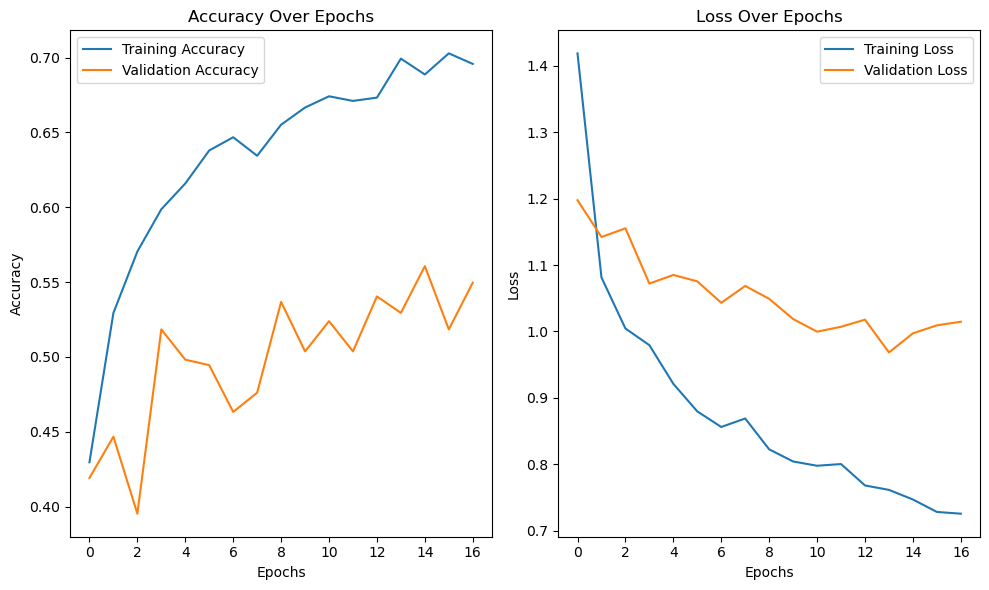

In [36]:
# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()

In [46]:

# Save the history record to csv
h_df.to_csv('./TrainingHistory/h_df.csv', index=False, header = True)

In [47]:
# save the entire model as .h5 file
model.save('./ModelHistory/ccn_resnet50_model_history.h5')

##### Model optimisations Methods

#### Model Optimisation Method 1 
#####  Use Data augmentation 



In [52]:
# Load the saved model
loaded_model_opt1 = load_model('./ModelHistory/ccn_resnet50_model_history.h5')
loaded_model_opt1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________


In [53]:
# Define the dataset paths
dataset_path = "Dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Define data augmentation parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [54]:
# Data augmentation for training dataset
train_datagen_opt1 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)


# Load training data with validation split
train_data_opt1 = train_datagen_opt1.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data_opt1 = train_datagen_opt1.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Data augmentation for testing dataset
test_datagen_opt1 = ImageDataGenerator(rescale=1./255)

# Load testing data
test_data = test_datagen_opt1.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2297 images belonging to 4 classes.
Found 573 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [55]:
# Compile the loaded model with data augmentation
loaded_model_opt1.compile(optimizer=Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [56]:
loaded_model_opt1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 49,279,108
Trainable params: 25,691,396
Non-trainable params: 23,587,712
_________________________________________________________________


In [57]:
# Train the model with data augmentation
history_opt1 = loaded_model_opt1.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    steps_per_epoch=train_data.samples // BATCH_SIZE,
    validation_steps=val_data.samples // BATCH_SIZE
)

Epoch 1/10


2024-10-27 18:13:45.691251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


71/71 [==============================] - ETA: 0s - loss: 1.2076 - accuracy: 0.4327

2024-10-27 18:14:44.612288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


71/71 [==============================] - 74s 1s/step - loss: 1.2076 - accuracy: 0.4327 - val_loss: 1.2583 - val_accuracy: 0.3787
Epoch 2/10
71/71 [==============================] - 72s 1s/step - loss: 1.1968 - accuracy: 0.4322 - val_loss: 1.2811 - val_accuracy: 0.3824
Epoch 3/10
71/71 [==============================] - 71s 1s/step - loss: 1.1746 - accuracy: 0.4313 - val_loss: 1.2784 - val_accuracy: 0.3658
Epoch 4/10
71/71 [==============================] - 71s 998ms/step - loss: 1.1780 - accuracy: 0.4344 - val_loss: 1.2285 - val_accuracy: 0.3842
Epoch 5/10
71/71 [==============================] - 73s 1s/step - loss: 1.1934 - accuracy: 0.4296 - val_loss: 1.2545 - val_accuracy: 0.3934
Epoch 6/10
71/71 [==============================] - 74s 1s/step - loss: 1.1867 - accuracy: 0.4344 - val_loss: 1.2576 - val_accuracy: 0.4375
Epoch 7/10
71/71 [==============================] - 74s 1s/step - loss: 1.1830 - accuracy: 0.4415 - val_loss: 1.2523 - val_accuracy: 0.4026
Epoch 8/10
71/71 [==========

In [58]:
# Evaluate the model on the test data
test_loss, test_acc = loaded_model_opt1.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

2024-10-27 18:35:45.444136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 17s 1s/step - loss: 2.7681 - accuracy: 0.3452
Test Loss: 2.768084764480591
Test Accuracy: 34.52%


In [59]:
# Predictions and classification report
Y_pred = loaded_model_opt1.predict(test_data)
y_pred = np.argmax(Y_pred, axis=1)

print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names=list(test_data.class_indices.keys())))

2024-10-27 18:38:18.665287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


13/13 [==============================] - 11s 768ms/step
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.33      0.13      0.19       100
meningioma_tumor       0.40      0.39      0.39       115
        no_tumor       0.38      0.55      0.45       105
 pituitary_tumor       0.23      0.27      0.25        74

        accuracy                           0.35       394
       macro avg       0.33      0.34      0.32       394
    weighted avg       0.34      0.35      0.33       394



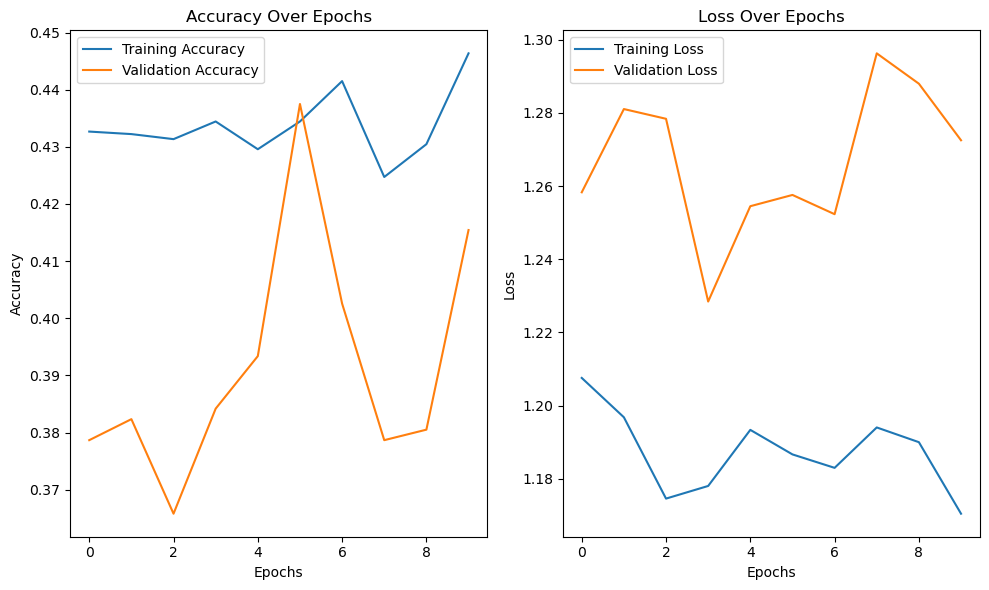

In [60]:
# Plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(history_opt1.history['accuracy'], label='Training Accuracy')
plt.plot(history_opt1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_opt1.history['loss'], label='Training Loss')
plt.plot(history_opt1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.tight_layout()
plt.show()